In [299]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [300]:
data_url = "https://data.insideairbnb.com/united-states/ny/new-york-city/2025-01-03/visualisations/listings.csv"
df = pd.read_csv(data_url)
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,2595,Skylit Midtown Castle Sanctuary,2845,Jennifer,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,240.0,30,49,2022-06-21,0.27,3,365,0,NaN
1,6848,Only 2 stops to Manhattan studio,15991,Allen & Irina,Brooklyn,Williamsburg,40.70935,-73.95342,Entire home/apt,81.0,30,195,2024-10-05,1.03,1,196,4,NaN
2,6872,Uptown Sanctuary w/ Private Bath (Month to Month),16104,Kahshanna,Manhattan,East Harlem,40.80107,-73.94255,Private room,65.0,30,1,2022-06-05,0.03,2,83,0,NaN
3,6990,UES Beautiful Blue Room,16800,Cyn,Manhattan,East Harlem,40.78778,-73.94759,Private room,70.0,30,251,2024-12-01,1.36,1,8,5,NaN
4,7064,"Amazing location! Wburg. Large, bright & tranquil",17297,Joelle,Brooklyn,Williamsburg,40.71248,-73.95881,Private room,NaN,30,13,2022-09-12,0.07,2,0,0,NaN


Dropping the name| host_name| host_id as there is no direct correlation of the user to the price based on experience.

In [301]:
df = df.drop(columns=['id', 'name', 'host_id', 'host_name'])

Checking for missing values in the dataset

In [302]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

price                14815
last_review          11892
reviews_per_month    11892
license              32398
dtype: int64

Dropping prices with null values as we need to predict the price or use the price as the outcome.

In [303]:
# Drop rows where 'price' is null
df = df.dropna(subset=['price'])
df.count()

neighbourhood_group               22969
neighbourhood                     22969
latitude                          22969
longitude                         22969
room_type                         22969
price                             22969
minimum_nights                    22969
number_of_reviews                 22969
last_review                       15917
reviews_per_month                 15917
calculated_host_listings_count    22969
availability_365                  22969
number_of_reviews_ltm             22969
license                            4548
dtype: int64

In [304]:
# Calculate the percentage of missing values for each column
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Display the percentage of missing values for columns that have missing data
missing_percentage[missing_percentage > 0]

last_review          30.702251
reviews_per_month    30.702251
license              80.199399
dtype: float64

In [305]:
# Dropping the 'license' column due to high percentage of missing values
df = df.drop(columns=['license'])

# Dropping the latitude and longitude as well since we have neighborhood
df = df.drop(columns=['latitude','longitude'])

Last review helps in identifying certain positive or negative trends on the property.
Also helps with reviewing the freshness of the property.
Hence we will convert it to a meaningful data set of the days since last review.

In [306]:
# Convert 'last_review' to datetime format
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

# If 'last_review' is NaT, assign a large number of days (e.g., 3650 days for 10 years)
df['days_since_last_review'] = (pd.to_datetime('today') - df['last_review']).dt.days

# Fill NaN values in 'days_since_last_review' with 3650 (10 years) directly
df['days_since_last_review'] = df['days_since_last_review'].fillna(3650)

In [307]:
# Fill NaN values in 'reviews_per_month' with 0 (indicating no reviews)
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

df.head()

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,days_since_last_review
0,Manhattan,Midtown,Entire home/apt,240.0,30,49,2022-06-21,0.27,3,365,0,971.0
1,Brooklyn,Williamsburg,Entire home/apt,81.0,30,195,2024-10-05,1.03,1,196,4,134.0
2,Manhattan,East Harlem,Private room,65.0,30,1,2022-06-05,0.03,2,83,0,987.0
3,Manhattan,East Harlem,Private room,70.0,30,251,2024-12-01,1.36,1,8,5,77.0
5,Brooklyn,Fort Greene,Private room,205.0,2,395,2024-12-21,2.17,2,261,36,57.0


In [308]:
# Calculate the percentage of missing values for each column
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Display the percentage of missing values for columns that have missing data
missing_percentage[missing_percentage > 0]

last_review    30.702251
dtype: float64

The columns don't have much relation with each other.
We can use one hot encoding to get the 1st correlation matrix.
Dropping neighbourhood for doing basic analysis.

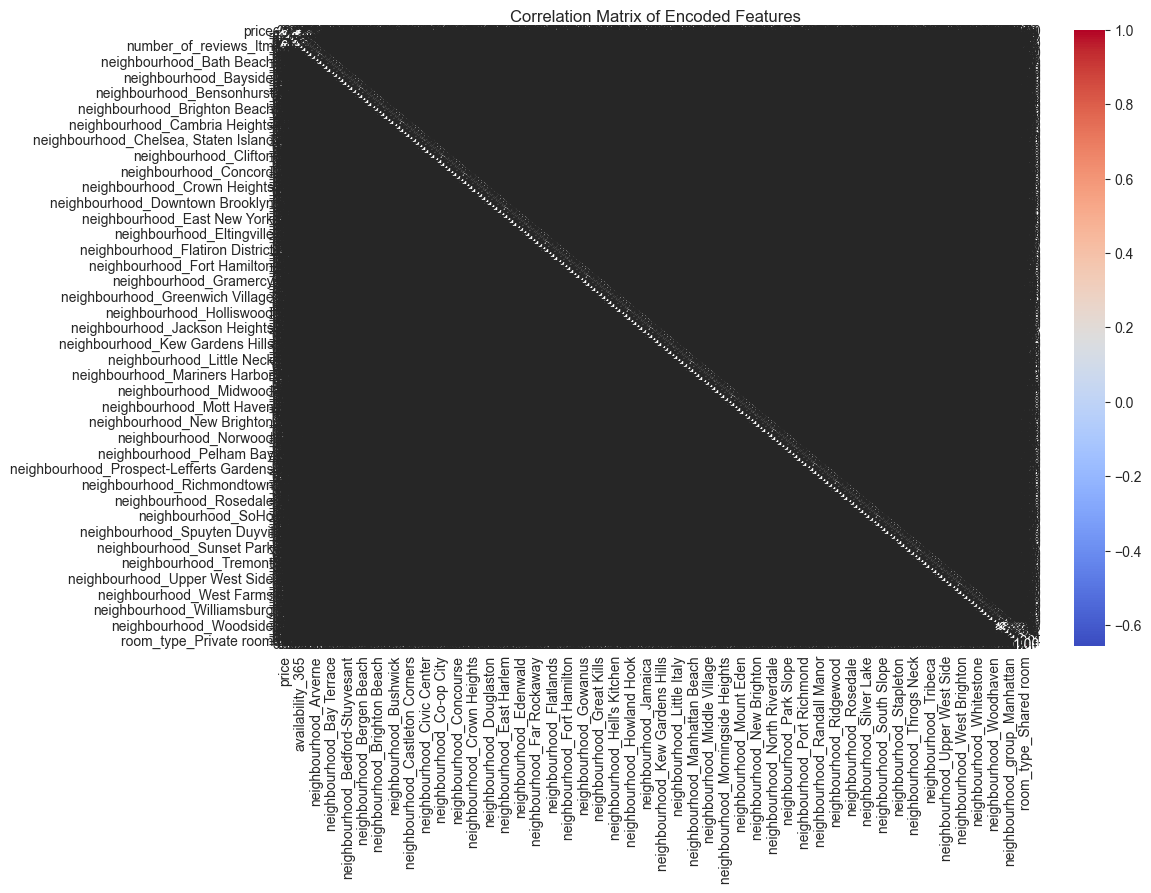

In [309]:
df = df.drop(columns=['last_review'])
# Apply One-Hot Encoding for categorical columns
df_encoded = pd.get_dummies(df, columns=['neighbourhood','neighbourhood_group', 'room_type'], drop_first=True)
# Compute the correlation matrix
correlation_matrix = df_encoded.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Encoded Features')
plt.show()

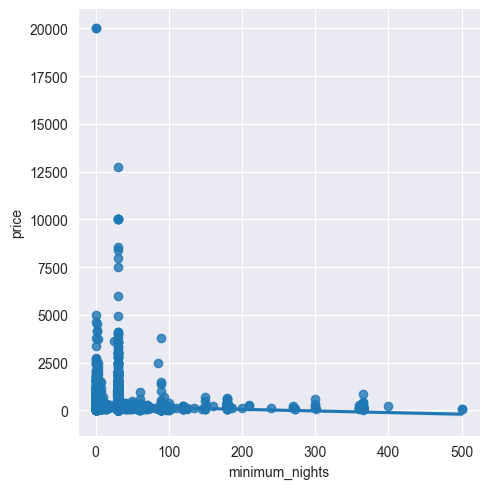

In [310]:
sns.lmplot(x='minimum_nights', y='price', data=df);

Higher the number of minimum nights, lesser the price.


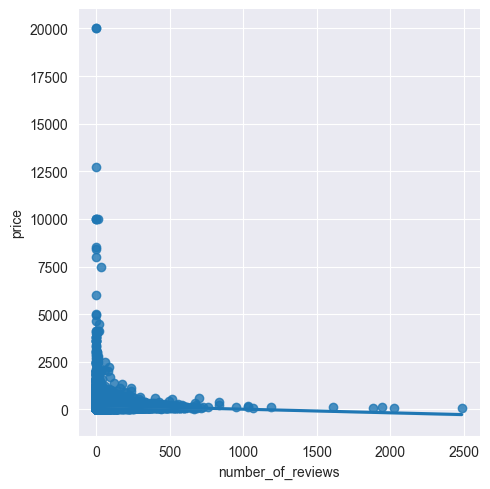

In [311]:
sns.lmplot(x='number_of_reviews', y='price', data=df);

In [312]:
# Calculate correlation matrix
corr_matrix = df_encoded.corr()

# Find highly correlated features
high_corr_features = np.where(abs(corr_matrix) > 0.8)
high_corr_features = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_features) if x != y]

# Print correlated feature pairs
print("Highly correlated features:", high_corr_features)


Highly correlated features: [('reviews_per_month', 'number_of_reviews_ltm'), ('number_of_reviews_ltm', 'reviews_per_month')]


In [313]:
df = df.drop(columns=['reviews_per_month','number_of_reviews_ltm'])

In [298]:
# Apply One-Hot Encoding for categorical columns
df_encoded = pd.get_dummies(df, columns=['neighbourhood', 'room_type'], drop_first=True)
# Compute the correlation matrix
correlation_matrix = df_encoded.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Encoded Features')
plt.show()

ValueError: could not convert string to float: 'Manhattan'

In [296]:
# Using the Linear Regression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Target variable (price)
y = df_encoded["price"]
X = df_encoded.drop(columns=["price", "last_review"], errors="ignore")
# Split dataset: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred = lr_model.predict(X_test)

# Evaluate performance
print(f"Linear Regression MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Linear Regression MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Linear Regression R² Score: {r2_score(y_test, y_pred):.2f}")

Training set size: (18375, 233)
Test set size: (4594, 233)
Linear Regression MAE: 113.47
Linear Regression MSE: 136283.43
Linear Regression R² Score: 0.05


In [297]:
# Using the Ridge Regressor model once
from sklearn.linear_model import Ridge

# Train Ridge model
ridge_model = Ridge(alpha=10.0)  # Adjust alpha for better results
ridge_model.fit(X_train, y_train)

# Predictions
y_pred_ridge = ridge_model.predict(X_test)

# Evaluate Ridge model
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
print(f"Ridge Regression MAE: {mean_absolute_error(y_test, y_pred_ridge):.2f}")
print(f"Ridge Regression MSE: {mean_squared_error(y_test, y_pred_ridge):.2f}")
print(f"Ridge Regression R² Score: {r2_score(y_test, y_pred_ridge):.2f}")


Ridge Regression MAE: 112.15
Ridge Regression MSE: 134705.90
Ridge Regression R² Score: 0.06


In [232]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest model
print(f"Random Forest MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"Random Forest MSE: {mean_squared_error(y_test, y_pred_rf):.2f}")
print(f"Random Forest R² Score: {r2_score(y_test, y_pred_rf):.2f}")


Random Forest MAE: 97.82
Random Forest MSE: 119431.73
Random Forest R² Score: 0.17


I Used a linear regression model exclusing with neighbourhood 1st </br>
Got the best results by including the neigbourhood. </br>
RandomForestRegressor was something that gave the best results, still bad though :(